In [1]:
import os
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
RAW_DATA_DIR = "../data/raw/"

In [3]:
def white_string_to_nan(data):
    return data.replace(r'^\s*$', np.nan, regex=True)

In [4]:
customers = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_customers_dataset.csv', engine="pyarrow"))
geolocation = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_geolocation_dataset.csv', engine="pyarrow"))
orders = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_orders_dataset.csv', engine="pyarrow"))
order_items = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_order_items_dataset.csv', engine="pyarrow"))
order_payments = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_order_payments_dataset.csv', engine="pyarrow"))
order_reviews = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_order_reviews_dataset.csv', engine="pyarrow"))
products = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_products_dataset.csv', engine="pyarrow"))
sellers = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'olist_sellers_dataset.csv', engine="pyarrow"))
product_category_translation = white_string_to_nan(pd.read_csv(RAW_DATA_DIR + 'product_category_name_translation.csv', engine="pyarrow"))

In [5]:
def skim(data):
    summary = pd.DataFrame({
                    'column': data.columns.values,
                    'type': data.dtypes.values,
                    'n_unique': data.nunique().values,
                    'n_missing': data.isna().sum().reset_index()[0],
                    'pct_missing': round(data.isna().sum().reset_index()[0]/len(data)*100, 2),
                    'min': data.dropna().min().values,
                    'max': data.dropna().max().values
                })
    return summary

## Merge Datasets

### Order Items

In [6]:
raw_dataset = orders.merge(order_items, on="order_id", how="left")
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   customer_id                    113425 non-null  object        
 2   order_status                   113425 non-null  object        
 3   order_purchase_timestamp       113425 non-null  datetime64[ns]
 4   order_approved_at              113264 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  float64       
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

### Products Category Name & Translation

In [7]:
products.info()
skim(products)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


,column,type,n_unique,n_missing,pct_missing,min,max
0,product_id,object,32951,0,0.00,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58
1,product_category_name,object,73,610,1.85,agro_industria_e_comercio,utilidades_domesticas
2,product_name_lenght,float64,66,610,1.85,5.0,76.0
3,product_description_lenght,float64,2960,610,1.85,4.0,3992.0
4,product_photos_qty,float64,19,610,1.85,1.0,20.0
5,product_weight_g,float64,2204,2,0.01,0.0,40425.0
6,product_length_cm,float64,99,2,0.01,7.0,105.0
7,product_height_cm,float64,102,2,0.01,2.0,105.0
8,product_width_cm,float64,95,2,0.01,6.0,118.0


In [8]:
product_category_translation.info()
skim(product_category_translation)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


,column,type,n_unique,n_missing,pct_missing,min,max
0,product_category_name,object,71,0,0.0,agro_industria_e_comercio,utilidades_domesticas
1,product_category_name_english,object,71,0,0.0,agro_industry_and_commerce,watches_gifts


In [9]:
product_category_unique = pd.DataFrame(products["product_category_name"].dropna().unique(), columns=["product_category_name"])
merged_temp = product_category_unique.merge(product_category_translation, on="product_category_name", how="left")
merged_temp[(merged_temp["product_category_name"].str.contains("_2") | merged_temp["product_category_name_english"].isna())]

,product_category_name,product_category_name_english
43,eletrodomesticos_2,home_appliances_2
63,pc_gamer,NaN
68,casa_conforto_2,home_comfort_2
69,portateis_cozinha_e_preparadores_de_alimentos,NaN


In [10]:
products.replace(to_replace="_2", value="", regex=True, inplace=True)
product_category_translation = product_category_translation[~product_category_translation["product_category_name"].str.contains("_2")]

In [11]:
new_category = pd.DataFrame({"product_category_name": ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
                             "product_category_name_english": ["pc_gamer", "portable_kitchen_and_food_processors"]})
product_category_translation = pd.concat([product_category_translation, new_category], ignore_index=True)
product_category_translation

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,fraldas_higiene,diapers_and_hygiene
67,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
68,seguros_e_servicos,security_and_services
69,pc_gamer,pc_gamer


In [12]:
raw_dataset = raw_dataset.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   customer_id                    113425 non-null  object        
 2   order_status                   113425 non-null  object        
 3   order_purchase_timestamp       113425 non-null  datetime64[ns]
 4   order_approved_at              113264 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  float64       
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [13]:
raw_dataset = raw_dataset.merge(product_category_translation, on="product_category_name", how="left")
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   customer_id                    113425 non-null  object        
 2   order_status                   113425 non-null  object        
 3   order_purchase_timestamp       113425 non-null  datetime64[ns]
 4   order_approved_at              113264 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  float64       
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [14]:
raw_dataset["product_category_name"].fillna("diversas", inplace=True)
raw_dataset["product_category_name_english"].fillna("miscellaneous", inplace=True)
raw_dataset[["product_category_name", "product_category_name_english"]].isna().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

### Customers

In [15]:
raw_dataset = raw_dataset.merge(customers, on="customer_id", how="left")
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113425 non-null  object        
 1   customer_id                    113425 non-null  object        
 2   order_status                   113425 non-null  object        
 3   order_purchase_timestamp       113425 non-null  datetime64[ns]
 4   order_approved_at              113264 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111457 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113425 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  float64       
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

### Order Payments

In [16]:
raw_dataset = raw_dataset.merge(order_payments, on="order_id", how="left")
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  datetime64[ns]
 4   order_approved_at              118258 non-null  datetime64[ns]
 5   order_delivered_carrier_date   116360 non-null  datetime64[ns]
 6   order_delivered_customer_date  115037 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118434 non-null  datetime64[ns]
 8   order_item_id                  117604 non-null  float64       
 9   product_id                     117604 non-null  object        
 10  seller_id                      117604 non-null  object        
 11  

### Order Reviews

In [17]:
raw_dataset = raw_dataset.merge(order_reviews, on="order_id", how="left")
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              118966 non-null  datetime64[ns]
 5   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 6   order_delivered_customer_date  115722 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119143 non-null  datetime64[ns]
 8   order_item_id                  118310 non-null  float64       
 9   product_id                     118310 non-null  object        
 10  seller_id                      118310 non-null  object        
 11  

### sort by Order Purchase Timestamp

In [18]:
raw_dataset.sort_values(by=["order_purchase_timestamp", "customer_id", "order_id", "order_item_id"], inplace=True, ignore_index=True)

## Handling Missing Values

### Order Review Titles, Messages

In [19]:
raw_dataset["review_comment_title"].fillna("no title", inplace=True)
raw_dataset["review_comment_message"].fillna("no message", inplace=True)

In [20]:
raw_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
order_item_id                     833
product_id                        833
seller_id                         833
shipping_limit_date               833
price                             833
freight_value                     833
product_category_name               0
product_category_name_english       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
review_id                         997
review_score                      997
review_comme

### Order Approved At

In [21]:
raw_dataset[raw_dataset["order_approved_at"].isna()]["order_status"].value_counts()

order_status
canceled     157
delivered     15
created        5
Name: count, dtype: int64

In [22]:
raw_dataset["order_status"].value_counts()

order_status
delivered      115723
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: count, dtype: int64

### Order Item ID

In [23]:
raw_dataset[raw_dataset["order_item_id"].isna()].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                162
order_delivered_carrier_date     832
order_delivered_customer_date    833
order_estimated_delivery_date      0
order_item_id                    833
product_id                       833
seller_id                        833
shipping_limit_date              833
price                            833
freight_value                    833
product_category_name              0
product_category_name_english      0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
review_id                         19
review_score                      19
review_comment_title               0
r

In [24]:
raw_dataset[raw_dataset["order_item_id"].isna()]["order_status"].value_counts()

order_status
unavailable    645
canceled       180
created          5
invoiced         2
shipped          1
Name: count, dtype: int64

### Order Review ID

In [25]:
raw_dataset[raw_dataset["review_id"].isna()].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  5
order_delivered_carrier_date      38
order_delivered_customer_date    136
order_estimated_delivery_date      0
order_item_id                     19
product_id                        19
seller_id                         19
shipping_limit_date               19
price                             19
freight_value                     19
product_category_name              0
product_category_name_english      0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
review_id                        997
review_score                     997
review_comment_title               0
r

In [26]:
raw_dataset[raw_dataset["review_id"].isna()]["order_status"].value_counts()

order_status
delivered      861
shipped         88
canceled        20
unavailable     14
invoiced         6
processing       6
created          2
Name: count, dtype: int64

## Handling Ambiguity (Negative, Zero Values)

In [27]:
skim(raw_dataset)

,column,type,n_unique,n_missing,pct_missing,min,max
0,order_id,object,99441,0,0.00,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244
1,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffa3172527f765de70084a7e53aae8
2,order_status,object,8,0,0.00,canceled,delivered
3,order_purchase_timestamp,datetime64[ns],98875,0,0.00,2016-10-03 09:44:50,2018-08-29 15:00:37
4,order_approved_at,datetime64[ns],90733,177,0.15,2016-10-04 09:43:32,2018-08-29 15:10:26
5,order_delivered_carrier_date,datetime64[ns],81018,2086,1.75,2016-10-08 10:34:01,2018-09-11 19:48:28
6,order_delivered_customer_date,datetime64[ns],95664,3421,2.87,2016-10-11 13:46:32,2018-10-17 13:22:46
7,order_estimated_delivery_date,datetime64[ns],459,0,0.00,2016-10-27 00:00:00,2018-10-25 00:00:00
8,order_item_id,float64,21,833,0.70,1.0,21.0
9,product_id,object,32951,833,0.70,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58


In [28]:
raw_dataset[raw_dataset["freight_value"]==0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
27125,2f3a10460f829a155fddd925f0e2f9c5,6a7ca7365d53fad7a6b7dd45406112de,delivered,2017-08-25 10:24:47,2017-08-25 10:35:12,2017-08-29 18:22:46,2017-09-06 17:53:00,2017-09-25,1.0,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-04 10:35:12,195.0,0.0,cama_mesa_banho,bed_bath_table,c9b9e60e5338143a868611fd96e30b8f,95630,parobe,RS,1.0,credit_card,8.0,195.0,b027af18ec34792131871915bdb55a89,5.0,no title,"AMEI,TAPETE LINDO... INCLUSIVE QUERO COMPRAR O...",2017-09-07,2017-09-08 13:56:45
27141,34a0606eca141f2c9ccb352883ee3fbe,18a7aeb193cba51394e6c333230dbfb0,delivered,2017-08-25 11:48:54,2017-08-25 12:04:45,2017-08-29 18:22:08,2017-09-01 21:42:48,2017-09-21,1.0,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-04 12:04:45,195.0,0.0,cama_mesa_banho,bed_bath_table,eee7de395b0d7af40c1f63fbd8c858a2,86020,londrina,PR,1.0,credit_card,6.0,195.0,3caa0360e752a845e85df61fbe3fb139,5.0,no title,no message,2017-09-04,2017-09-04 11:13:31
27181,d8751e37cdb2166fa6df8a8ebc346768,65a23aa6cfab2172891731a229c0958a,delivered,2017-08-25 15:24:20,2017-08-26 02:24:30,2017-08-31 15:19:13,2017-09-14 18:44:47,2017-09-19,1.0,4fcb3d9a5f4871e8362dfedbdb02b064,8581055ce74af1daba164fdbd55a40de,2017-08-31 02:24:30,164.9,0.0,automotivo,auto,3041bf14421b7d218b3daa4a909199c8,35300,caratinga,MG,1.0,boleto,1.0,164.9,02a6604e65c037d174fb5c2ba0f43f43,4.0,no title,"Demorou um pouco a entrega, mas a culpa foi do...",2017-09-15,2017-09-18 17:53:44
27226,ca860fbc7c3132b89e9e134a00652215,043b3cac6240fc110a721919bd6dea93,delivered,2017-08-25 22:08:13,2017-08-29 04:25:55,2017-08-29 16:23:53,2017-09-12 20:39:56,2017-09-18,1.0,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-06 04:25:55,195.0,0.0,cama_mesa_banho,bed_bath_table,d87cf110269f58faa16ef95b748b702c,25075,duque de caxias,RJ,1.0,boleto,1.0,195.0,055ef7374650682b7a4bd157deebb826,2.0,no title,Não gostei muito da qualidade do produto.,2017-09-13,2017-09-14 10:16:16
27228,a946d303fa4b1b68eebaf28216e3442a,baa47b562bdd4118b6b923aa24b14119,delivered,2017-08-25 22:57:02,2017-08-25 23:10:10,2017-08-29 18:33:38,2017-09-04 20:33:30,2017-09-20,1.0,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-03 23:10:10,195.0,0.0,cama_mesa_banho,bed_bath_table,040771bb467e731e2f7946b575c319be,29890,montanha,ES,1.0,credit_card,8.0,195.0,4230701eb4cfe7b1ce69c51c559699e6,4.0,no title,Achei o tapete super lindo...só pensei que fos...,2017-09-05,2017-09-06 01:28:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95919,1a2582ca80feaaf937cc94d437ba1635,99efadd052716ca57a64a6287caca0eb,delivered,2018-05-26 07:45:36,2018-05-26 08:19:48,2018-05-28 13:19:00,2018-06-09 15:42:09,2018-07-16,1.0,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-06-04 08:19:48,69.9,0.0,moveis_decoracao,furniture_decor,ca036474affd5477396f50769f54ebdc,55900,goiana,PE,1.0,credit_card,1.0,69.9,cc93f513b768b0abc7af5ff3948ae7c9,4.0,no title,"O pedido chegou antes da data prevista, satisf...",2018-06-10,2018-06-15 21:29:09
95925,765f62aa9ec878cf62b1533261ae8e87,68d430cabd68310e0732347be5e9be22,delivered,2018-05-26 08:58:34,2018-05-26 09:15:12,2018-05-28 13:19:00,2018-06-11 17:52:45,2018-06-29,1.0,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-06-04 09:15:12,69.9,0.0,moveis_decoracao,furniture_decor,12d20cdd868f3abd1c95a1c75056577d,29702,

In [29]:
raw_dataset[raw_dataset["payment_installments"]==0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
86064,744bade1fcf9ff3f31d860ace076d422,5e5794daaa13f73e2f1cdb4114529843,delivered,2018-04-22 11:34:42,2018-04-24 19:04:46,2018-04-24 03:14:34,2018-04-27 20:55:28,2018-05-16,1.0,0cf573090c66bb30ac5e53c82bdb0403,7202e2ba20579a9bd1acb29e61fe71f6,2018-04-26 12:31:06,45.90,12.79,telefonia,telephony,f54cea27c80dc09bfe07b1cf1e01b845,5263,sao paulo,SP,2.0,credit_card,0.0,58.69,c56b4b7042f417e70d3dc5340deb23fe,5.0,no title,no message,2018-04-28,2018-04-29 17:43:50
93453,1a57108394169c0b47d8f876acc9ba2d,48ebb06cf56dba9d009230cc751bb195,delivered,2018-05-15 16:25:14,2018-05-15 16:36:52,2018-05-17 12:37:00,2018-05-24 15:45:41,2018-06-06,1.0,db35a562fb6ba63e19fa42a15349dc04,282f23a9769b2690c5dda22e316f9941,2018-05-18 16:31:54,41.69,23.28,utilidades_domesticas,housewares,9925e1d7dff0d807355599dee04830ab,44001,feira de santana,BA,2.0,credit_card,0.0,129.94,bc5dca6c957c328b1cbff760b0841fd2,5.0,no title,no message,2018-05-25,2018-05-26 00:24:28
93454,1a57108394169c0b47d8f876acc9ba2d,48ebb06cf56dba9d009230cc751bb195,delivered,2018-05-15 16:25:14,2018-05-15 16:36:52,2018-05-17 12:37:00,2018-05-24 15:45:41,2018-06-06,2.0,db35a562fb6ba63e19fa42a15349dc04,282f23a9769b2690c5dda22e316f9941,2018-05-18 16:31:54,41.69,23.28,utilidades_domesticas,housewares,9925e1d7dff0d807355599dee04830ab,44001,feira de santana,BA,2.0,credit_card,0.0,129.94,bc5dca6c957c328b1cbff760b0841fd2,5.0,no title,no message,2018-05-25,2018-05-26 00:24:28


In [30]:
raw_dataset[raw_dataset["payment_value"]==0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
8507,fa65dad1b0e818e3ccc5cb0e39231352,9af2372a1e49340278e7c1ef8d749f34,shipped,2017-04-20 12:45:34,2017-04-22 09:10:13,2017-04-24 11:31:17,NaT,2017-05-18,1.0,1aecdb5fa3add74e385f25c6c527a462,06532f10282704ef4c69168b914b77be,2017-04-27 09:10:13,392.55,65.44,ferramentas_jardim,garden_tools,8af7ac63b2efbcbd88e5b11505e8098a,78065,cuiaba,MT,14.0,voucher,1.0,0.0,f28281373ab8815bafafe371218f02ce,1.0,no title,A mercadoria não foi entregue. Entrara em cont...,2017-05-21,2017-05-24 16:21:27
8516,fa65dad1b0e818e3ccc5cb0e39231352,9af2372a1e49340278e7c1ef8d749f34,shipped,2017-04-20 12:45:34,2017-04-22 09:10:13,2017-04-24 11:31:17,NaT,2017-05-18,1.0,1aecdb5fa3add74e385f25c6c527a462,06532f10282704ef4c69168b914b77be,2017-04-27 09:10:13,392.55,65.44,ferramentas_jardim,garden_tools,8af7ac63b2efbcbd88e5b11505e8098a,78065,cuiaba,MT,13.0,voucher,1.0,0.0,f28281373ab8815bafafe371218f02ce,1.0,no title,A mercadoria não foi entregue. Entrara em cont...,2017-05-21,2017-05-24 16:21:27
13544,b23878b3e8eb4d25a158f57d96331b18,648121b599d98c420ef93f6135f8c80c,delivered,2017-05-27 19:20:24,2017-05-27 19:35:17,2017-05-29 04:49:37,2017-06-07 08:53:10,2017-06-29,1.0,e306ca54c91b21392317d5b4632c9fe3,e49c26c3edfa46d227d5121a6b6e4d37,2017-06-01 19:35:17,135.30,36.27,consoles_games,consoles_games,9077449283dc1319d5e51fb3159b28e2,29230,anchieta,ES,4.0,voucher,1.0,0.0,f75bfd523e8001ea6c62f86c48fae8a9,5.0,no title,no message,2017-06-08,2017-06-10 19:28:35
15345,45ed6e85398a87c253db47c2d9f48216,8eab8f9b3c744b76b65f7a2c0c8f2d6c,delivered,2017-06-08 21:18:45,2017-06-08 21:30:18,2017-06-09 08:35:18,2017-06-22 17:44:53,2017-07-10,1.0,75d6b6963340c6063f7f4cfcccfe6a30,cc419e0650a3c5ba77189a1882b7556a,2017-06-15 21:30:18,56.99,14.15,perfumaria,perfumery,e4000306cf2f63714e6bb70dd20a6592,74595,goiania,GO,3.0,voucher,1.0,0.0,b59cf587845cad9af780a2f839ee6c30,1.0,no title,Produto demorou a chegar e veio diferente do q...,2017-06-23,2017-06-27 16:19:05
38286,6ccb433e00daae1283ccc956189c82ae,843b211abe7b0264dd4a69eafc5bdf43,delivered,2017-10-26 23:51:35,2017-10-27 00:46:58,2017-10-27 19:53:03,2017-11-08 18:47:00,2017-11-22,1.0,2ee4be9805f228255a38a6f9b03fff1a,da20530872245d6cd9d2f5725613c430,2017-11-03 00:46:58,94.00,28.04,esporte_lazer,sports_leisure,677ad9cdca6c47c733f0cc6e23d7bb4c,25625,petropolis,RJ,4.0,voucher,1.0,0.0,8d0e1d286cc6f63e3a784779c9d1f7d8,4.0,no title,no message,2017-11-09,2018-02-14 13:57:57
61772,8bcbe01d44d147f901cd3192671144db,f2def7f64f36952f2f5a9791f0285f34,delivered,2018-01-24 23:24:14,2018-01-24 23:37:20,2018-01-30 22:43:30,2018-02-02 21:26:42,2018-02-21,1.0,85d4c1a46f08f730de651ea6f6645313,3d871de0142ce09b7081e2b9d1733cb1,2018-01-30 23:37:20,59.00,15.16,papelaria,stationery,cc5aa1b8337e394da54980226bb0f6d4,21040,rio de janeiro,RJ,4.0,voucher,1.0,0.0,3d42038fd2a7d35a88b93cb3e51796a3,4.0,no title,no message,2018-02-03,2018-02-11 17:34:29
119073,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,NaN,NaN,NaN,NaT,NaN,NaN,diversas,miscellaneous,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,1.0,not_defined,1.0,0.0,9c0d840dfe562debfa52a1792bd64bff,1.0,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28,2018-08-28 18:25:55
119091,c8c528189310eaa44a745b8d9d26908b,197a2a6a77da93f678ea0d379f21da0a,canceled,2018-08-28 20:05:14,NaT,NaT,NaT,2018-09-11,NaN,NaN,NaN,NaT,NaN,NaN,diversas,miscellaneous,6ba987d564bad1f9da8e14b9d3b71c8f,80

## Handling Duplicated Values

In [31]:
raw_dataset[raw_dataset.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [32]:
raw_dataset[raw_dataset.duplicated(subset=["order_id", "order_item_id", "payment_sequential"], keep=False)].head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
388,b19169c7cb8391fb8561e094d61c531a,620732fed5579e0bdfdddee02aad4c54,delivered,2016-10-10 15:49:59,2016-10-10 16:02:54,2016-10-21 18:22:31,2016-10-28 14:43:41,2016-12-02,1.0,bdcec8e22b04a8f4241d87bcfe9ea877,d101c6da914ae3d53f7bee42283f2fe2,2016-10-21 16:35:49,28.90,14.11,moveis_decoracao,furniture_decor,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG,1.0,credit_card,10.0,129.03,f24e1946d658c13928818f1a73b6d899,5.0,no title,Excelente produto.\r\nObrigada,2016-10-27,2016-10-28 12:21:53
389,b19169c7cb8391fb8561e094d61c531a,620732fed5579e0bdfdddee02aad4c54,delivered,2016-10-10 15:49:59,2016-10-10 16:02:54,2016-10-21 18:22:31,2016-10-28 14:43:41,2016-12-02,1.0,bdcec8e22b04a8f4241d87bcfe9ea877,d101c6da914ae3d53f7bee42283f2fe2,2016-10-21 16:35:49,28.90,14.11,moveis_decoracao,furniture_decor,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG,1.0,credit_card,10.0,129.03,87159a093663b2a1bb847dbb84879c41,5.0,no title,Excelente produto.\r\nVendedor nota 1000,2016-10-29,2016-10-31 20:00:13
390,b19169c7cb8391fb8561e094d61c531a,620732fed5579e0bdfdddee02aad4c54,delivered,2016-10-10 15:49:59,2016-10-10 16:02:54,2016-10-21 18:22:31,2016-10-28 14:43:41,2016-12-02,2.0,bdcec8e22b04a8f4241d87bcfe9ea877,d101c6da914ae3d53f7bee42283f2fe2,2016-10-21 16:35:49,28.90,14.11,moveis_decoracao,furniture_decor,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG,1.0,credit_card,10.0,129.03,f24e1946d658c13928818f1a73b6d899,5.0,no title,Excelente produto.\r\nObrigada,2016-10-27,2016-10-28 12:21:53
391,b19169c7cb8391fb8561e094d61c531a,620732fed5579e0bdfdddee02aad4c54,delivered,2016-10-10 15:49:59,2016-10-10 16:02:54,2016-10-21 18:22:31,2016-10-28 14:43:41,2016-12-02,2.0,bdcec8e22b04a8f4241d87bcfe9ea877,d101c6da914ae3d53f7bee42283f2fe2,2016-10-21 16:35:49,28.90,14.11,moveis_decoracao,furniture_decor,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG,1.0,credit_card,10.0,129.03,87159a093663b2a1bb847dbb84879c41,5.0,no title,Excelente produto.\r\nVendedor nota 1000,2016-10-29,2016-10-31 20:00:13
392,b19169c7cb8391fb8561e094d61c531a,620732fed5579e0bdfdddee02aad4c54,delivered,2016-10-10 15:49:59,2016-10-10 16:02:54,2016-10-21 18:22:31,2016-10-28 14:43:41,2016-12-02,3.0,bdcec8e22b04a8f4241d87bcfe9ea877,d101c6da914ae3d53f7bee42283f2fe2,2016-10-21 16:35:49,28.90,14.11,moveis_decoracao,furniture_decor,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG,1.0,credit_card,10.0,129.03,f24e1946d658c13928818f1a73b6d899,5.0,no title,Excelente produto.\r\nObrigada,2016-10-27,2016-10-28 12:21:53
393,b19169c7cb8391fb8561e094d61c531a,620732fed5579e0bdfdddee02aad4c54,delivered,2016-10-10 15:49:59,2016-10-10 16:02:54,2016-10-21 18:22:31,2016-10-28 14:43:41,2016-12-02,3.0,bdcec8e22b04a8f4241d87bcfe9ea877,d101c6da914ae3d53f7bee42283f2fe2,2016-10-21 16:35:49,28.90,14.11,moveis_decoracao,furniture_decor,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG,1.0,credit_card,10.0,129.03,87159a093663b2a1bb847dbb84879c41,5.0,no title,Excelente produto.\r\nVendedor nota 1000,2016-10-29,2016-10-31 20:00:13
394,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10 15:50:01,2016-10-10 16:02:37,2016-10-18 15:53:51,2016-10-26 16:35:46,2016-12-14,1.0,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 16:35:46,39.99,11.80,moveis_decoracao,furniture_decor,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG,1.0,credit_card,5.0,51.79,f24e1946d658c13928818f1a73b6d899,5.0,no t

## Data Types

IDs (7):
* order_id
* customer_id
* order_item_id
* product_id
* seller_id
* customer_unique_id
* review_id

Categorical (6):
* order_status, low cardinality
* product_category_name, high cardinality
* product_category_name_english, high cardinality
* customer_city, high cardinality
* customer_state, high cardinality
* payment_type, low cardinality low

Datetime (8):
* order_purchase_timestamp
* order_approved_at
* order_delivered_carrier_date
* order_delivered_customer_date
* order_estimated_delivery_date
* shipping_limit_date
* review_create_date
* review_answer_timestamp

Numerical, Continuous (3):
* price
* freight_value
* payment_value

Numerical, Ordinal (1):
* review_score

Numerical, ??? (3)
* customer_zip_code_prefix, high cardinality
* payment_sequential, high cardinality
* payment_installments, high cardinality

Text (2):
* review_comment_title
* review_comment_message

## Handling Outliers

In [33]:
df_notna = raw_dataset.dropna()
df_notna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114842 entries, 8 to 119116
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114842 non-null  object        
 1   customer_id                    114842 non-null  object        
 2   order_status                   114842 non-null  object        
 3   order_purchase_timestamp       114842 non-null  datetime64[ns]
 4   order_approved_at              114842 non-null  datetime64[ns]
 5   order_delivered_carrier_date   114842 non-null  datetime64[ns]
 6   order_delivered_customer_date  114842 non-null  datetime64[ns]
 7   order_estimated_delivery_date  114842 non-null  datetime64[ns]
 8   order_item_id                  114842 non-null  float64       
 9   product_id                     114842 non-null  object        
 10  seller_id                      114842 non-null  object        
 11  shipp

### **Numerical, Continuous**

In [34]:
def distboxplot(data, bins, xticks, xlim, xlabel, unit, title=None, column=None, figsize=None):
    plt.style.use('default')
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        gridspec_kw={'height_ratios':[4,1]},
        sharex=True
    )

    if column:
        sns.histplot(data=data, x=column, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data=data, x=column, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data[column].mean()
        median = data[column].median()
        mad = abs(data[column] - data[column].median()).median()
    else:
        sns.histplot(data=data, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data.mean()
        median = data.median()
        mad = abs(data - data.median()).median()
    
    # create tendencies measurement lines
    axes[0].axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes[0].axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")

    axes[0].legend()
    axes[0].set_xlim(xlim[0], xlim[1])

    axes[1].set_xlabel(xlabel)
    axes[1].set_xticks(xticks)
    axes[1].set(yticklabels=[])

    if title:
        axes[0].set_title(title)
    plt.show();

#### **Price**

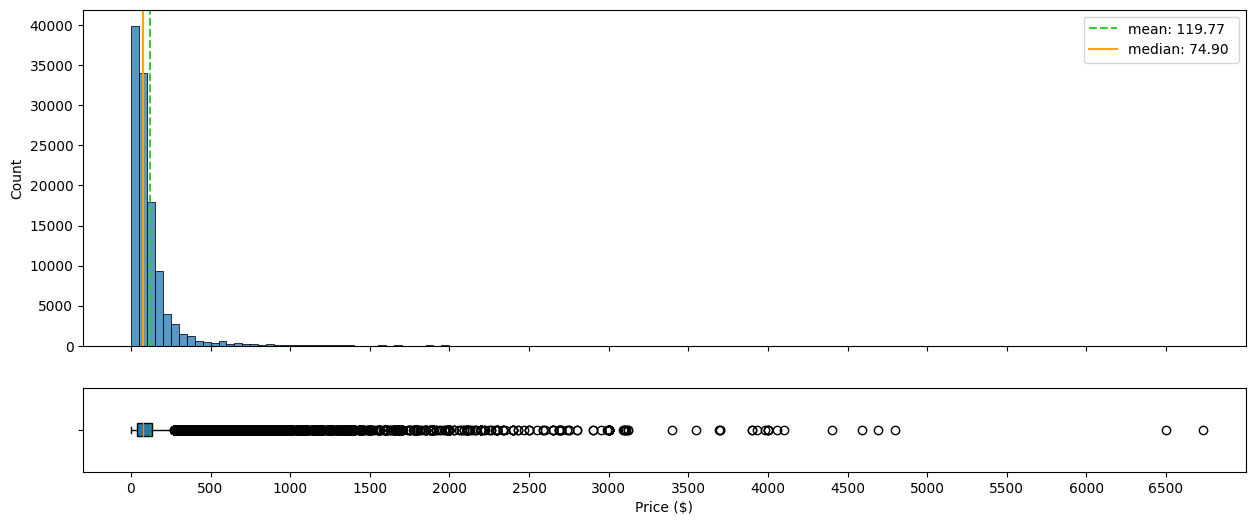

In [42]:
distboxplot(data=df_notna, column="price", bins=np.arange(0,7000,50),
            xticks=np.arange(0,7000,500), xlim=[-300,7000], xlabel="Price ($)", unit="",
            title=None, figsize=(15,6))

#### **Freight Value**

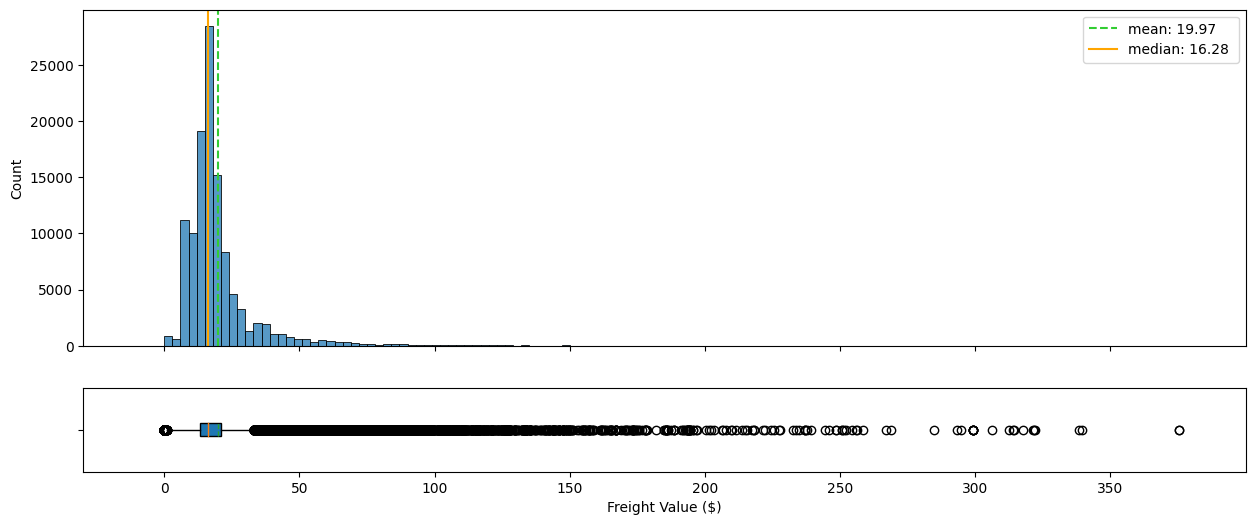

In [47]:
distboxplot(data=df_notna, column="freight_value", bins=np.arange(0,400,3),
            xticks=np.arange(0,400,50), xlim=[-30,400], xlabel="Freight Value ($)", unit="",
            title=None, figsize=(15,6))

#### **Payment Value**

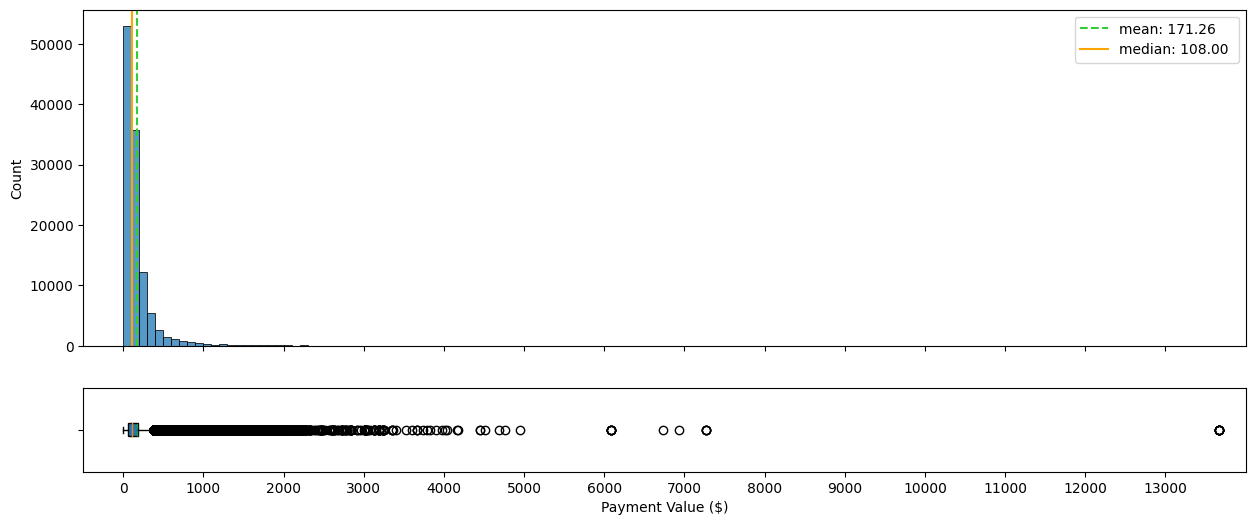

In [48]:
distboxplot(data=df_notna, column="payment_value", bins=np.arange(0,14000,100),
            xticks=np.arange(0,14000,1000), xlim=[-500,14000], xlabel="Payment Value ($)", unit="",
            title=None, figsize=(15,6))

### **Categorical**

#### **Order Status**

<Axes: xlabel='order_status', ylabel='count'>

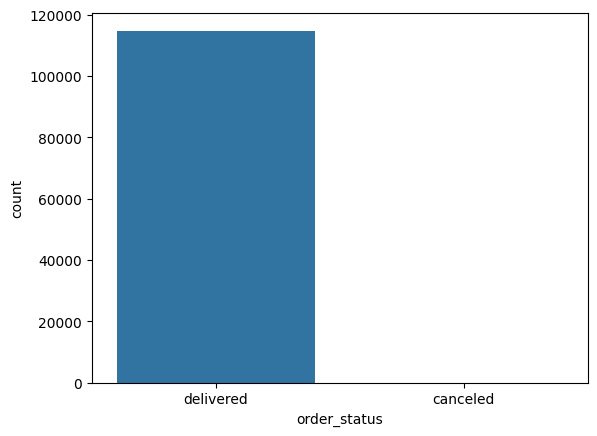

In [115]:
sns.countplot(data=df_notna, x="order_status")

#### **Product Category**

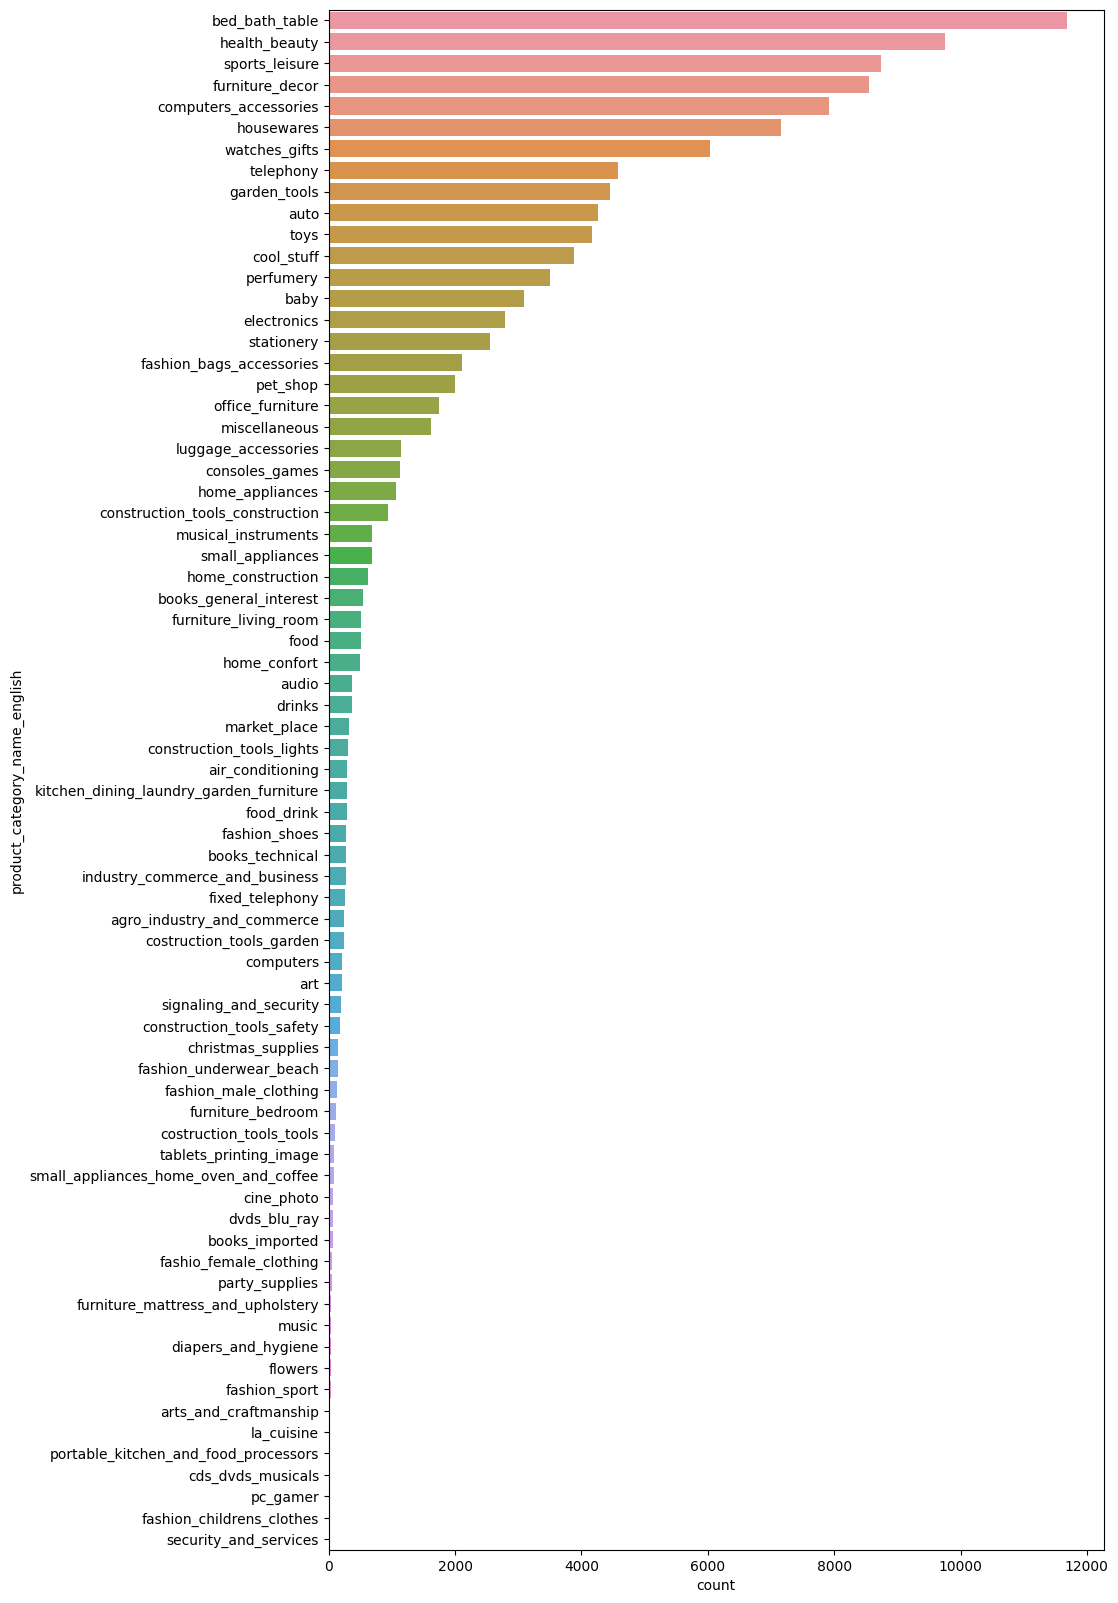

In [78]:
order = df_notna["product_category_name_english"].value_counts().index
plt.figure(figsize=(10,20))
sns.countplot(data=df_notna, y="product_category_name_english", order=order);

#### **Payment Type**

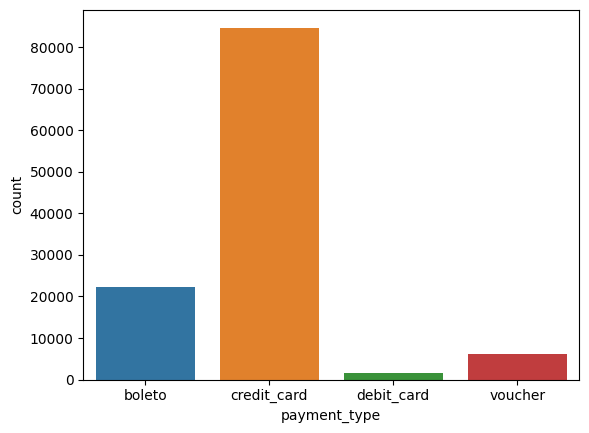

In [107]:
sns.countplot(data=df_notna, x="payment_type");

### **Numerical, ???**

#### **Payment Sequential**

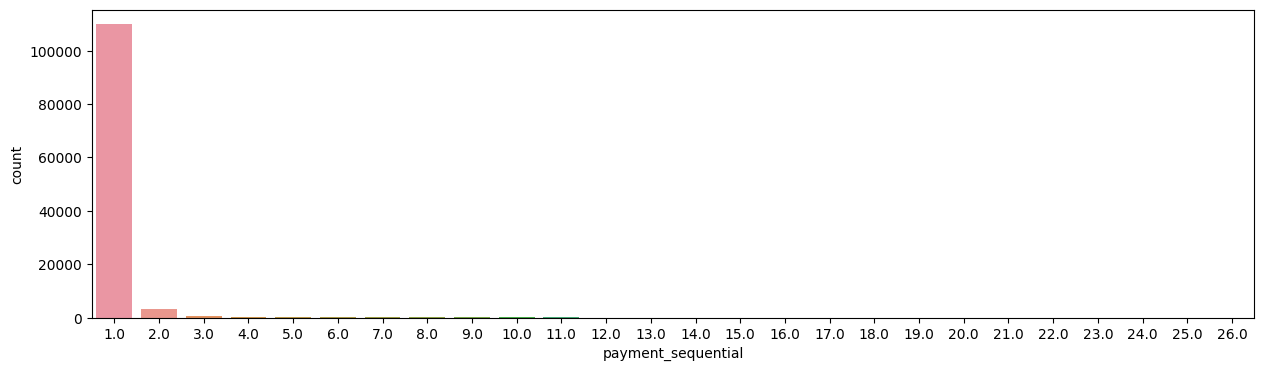

In [109]:
plt.figure(figsize=(15,4))
sns.countplot(data=df_notna, x="payment_sequential");

#### **Payment Installments**

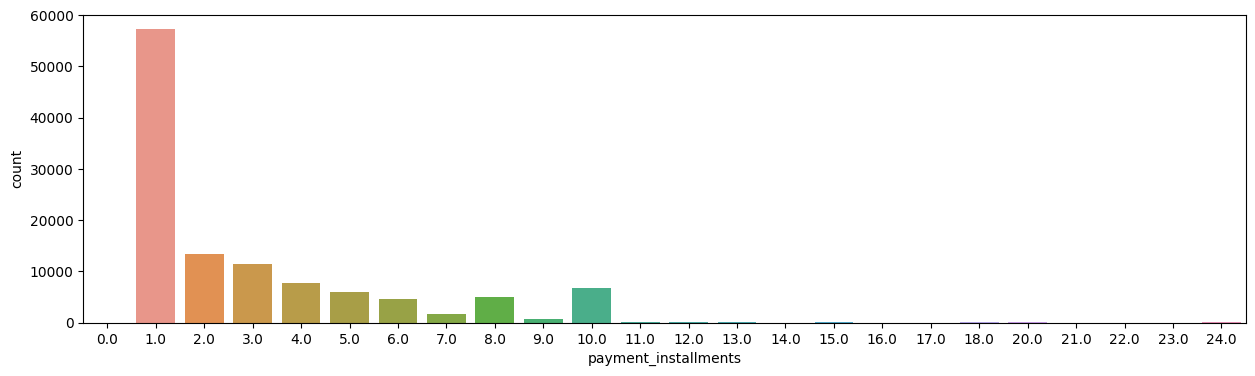

In [111]:
plt.figure(figsize=(15,4))
sns.countplot(data=df_notna, x="payment_installments");